<a href="https://colab.research.google.com/github/hfoffani/HF-fastai/blob/main/nb30_iula_blurr_blearner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq transformers datasets tqdm
!pip install -Uqq ohmeow-blurr

     |████████████████████████████████| 2.6 MB 10.6 MB/s 
     |████████████████████████████████| 264 kB 72.9 MB/s 
     |████████████████████████████████| 76 kB 6.0 MB/s 
     |████████████████████████████████| 636 kB 62.7 MB/s 
     |████████████████████████████████| 3.3 MB 56.1 MB/s 
     |████████████████████████████████| 895 kB 55.1 MB/s 
     |████████████████████████████████| 118 kB 60.9 MB/s 
     |████████████████████████████████| 243 kB 62.4 MB/s 
     |████████████████████████████████| 75 kB 3.8 MB/s 
     |████████████████████████████████| 1.2 MB 17.6 MB/s 
     |████████████████████████████████| 188 kB 71.8 MB/s 
     |████████████████████████████████| 43 kB 2.7 MB/s 
     |████████████████████████████████| 54 kB 3.5 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

import pandas as pd

from transformers import AutoModelForSequenceClassification

from blurr.utils import BLURR
from blurr.data.core import HF_TextBlock
from blurr.modeling.core import Blearner

from fastai.text.all import *


### Leer Corpus

In [4]:
co_df = pd.read_csv('/content/drive/MyDrive/iula-es.csv')
num_labels = co_df['label'].nunique()
co_df

,label,sentence,is_valid
0,economía,LOS POSTULADOS DE LA ECONOMÍA CLÁSICA,True
1,economía,"La mayor parte de los tratados sobre la teoría del valor y de la producción se refieren, en primer término, a la distribución de un volumen dado de recursos empleados en diferentes usos, y a las condiciones que, supuesta la ocupación de esta cantidad de recursos, determinen su remuneración relativa y el relativo valor de sus productos [1]",False
2,economía,"También se ha sujetado con frecuencia a un procedimiento descriptivo lo relativo al monto de los recursos disponibles (entendiendo por tales el volumen de población susceptible de tomar empleo), los límites de la riqueza natural y el equipo de producción acumulado; pero rara vez se ha examinado detenidamente en la teoría pura, la explicación de lo que determina la ocupación real de los recursos disponibles.",False
3,economía,"Decir que no se ha considerado en absoluto, seria absurdo, por supuesto; porque todo estudio sobre los altibajos de la ocupación, que han sido muchos, ha tenido que ver con el tema.",False
4,economía,"No quiero decir que se haya pasado por alto, sino que la teoría fundamental en que descansa se ha creído tan sencilla y evidente que casi no había para qué mencionarla [2]",False
...,...,...,...
52350,medicina,Diarrea.,True
52351,medicina,Debilidad.,False
52352,medicina,Gusto alterado.,False
52353,medicina,Parestesias peribucales.,False


### Modelar

In [5]:

# pretrained_model_name = "distilbert-base-uncased"
# pretrained_model_name = "bert-base-uncased"
# pretrained_model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
pretrained_model_name = "distilroberta-base"

In [6]:
model_cls = AutoModelForSequenceClassification

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(
    pretrained_model_name,
    model_cls=model_cls,
    config_kwargs={'num_labels': num_labels})

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/331M [00:00<?, ?B/s]

In [7]:
blocks = (HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), CategoryBlock)
dblock = DataBlock(blocks=blocks,
                   get_x=ColReader('sentence'),
                   get_y=ColReader('label'),
                   splitter=ColSplitter())

dls = dblock.dataloaders(co_df, bs=4, val_bs=8)

In [8]:
dls.show_batch(dataloaders=dls)

,text,category
0,"En una economía estacionaria quizá no valiera la pena mencionar todo esto, ya que en cada año los márgenes de tolerancia para la depreciación, con respecto a las casas viejas, quedarían compensados exactamente por las casas nuevas que se construyeran en sustitución de las que llegan al fin de su vida cada año; pero tales factores pueden ser de mucha importancia en una economía no estática, especialmente durante el periodo que sigue de inmediato a un vigoroso brote de inversión de capital a largo plazo; porque en tales circunstancias gran parte de las nuevas partidas de inversión puede ser absorbida por las mayores reservas financieras que hacen los empresarios para reparar y renovar el equipo de producción existente, el cual, aunque se desgasta con el tiempo, todavía no ha llegado a la fecha en que deben hacerse gastos que puedan aproximarse al total de la reserva financiera que se aparta; con la consecuencia de que los ingresos no pueden subir por encima de un nivel lo bastante bajo para corresponder a un total pequeño de inversión neta.",economía
1,"Además de jabones, champúes, lociones hidratantes o tintes para el cabello, la empresa ha puesto en el mercado el credo de su práctica cotidiana de rellenar, reciclar, reutilizar, la denuncia de la propaganda de los cosméticos que prometen milagros imposibles, el manifestarse contra los ensayos en animales, la protección de las comunidades indígenas mediante intercambios comerciales equitativos, el empleo de materias primas naturales y renovables y, por supuesto, el embarcarse en cuanta campaña sea necesaria para defender los derechos humanos allí donde estén amenazados.",ambiente
2,"Los ratones transgénicos que se obtienen (ver página 572 para una descripción de los principios básicos para la construcción de ratones transgénicos) producen un repertorio diverso de cadenas pesadas y ligeras de inmunoglobulinas humanas y, tras su inmunización con toxina tetánica, pueden utilizarse para derivar anticuerpos monoclonales específicos de naturaleza humana.",medicina
3,"En concreto, cualquier norma que se refiera a los fuelóleos debe tener en cuenta las disposiciones de la Directiva 88/609/CEE sobre limitación de emisiones a la atmósfera de determinados agentes contaminantes procedentes de grandes instalaciones de combustión, así como la propuesta de modificación de esa Directiva, y deberá guardar coherencia con la misma (véase el punto 4.4).",ambiente


In [9]:
b = dls.one_batch()

len(b), b[0]['input_ids'].shape, b[1].shape, dls.c

(2, torch.Size([4, 343]), torch.Size([4]), 5)

In [10]:
learn = Blearner(dls, hf_model,
                 metrics=[F1Score(average=None)])
learn = learn.to_fp16()
learn.freeze()


In [11]:
learn.summary()

HF_BaseModelWrapper (Input shape: 4)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 343 x 768       
Embedding                                 38603520   False     
Embedding                                 394752     False     
Embedding                                 768        False     
LayerNorm                                 1536       True      
Dropout                                                        
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
Dropout                                                        
Linear                                    590592     False     
LayerNorm                                 1536       True      
Dropout                                                        
____________________________________________________________________________
            

### Entrenar

SuggestedLRs(valley=0.0006918309954926372)

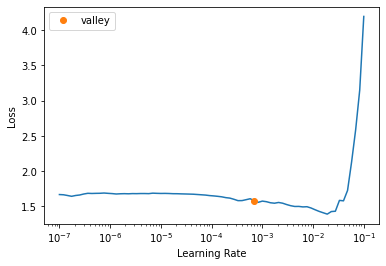

In [12]:
learn.lr_find()

In [13]:
learn.fit_one_cycle(1, lr_max=3e-3)

epoch,train_loss,valid_loss,f1_score,time
0,0.537727,0.466664,[0.62176789 0.62774505 0.60818713 0.88277214 0.8482128 ],04:39


In [14]:
learn.show_results(learner=learn, max_n=5)

,text,category,target
0,"Quedan reservadas, en todo caso, a las Fuerzas y Cuerpos de Seguridad del Estado bajo la dependencia del Gobierno los servicios policiales de carácter extracomunitario y supracomunitario como la vigilancia de puertos, aeropuertos, costas y fronteras, aduanas, control de entrada y salida del territorio nacional de españoles y extranjeros, régimen general de extranjería, extradición y expulsión, emigración e inmigración, pasaportes, documento nacional de identidad, trafico, armas y explosivos, resguardo fiscal del Estado, contrabando y fraude fiscal y las demás funciones que directamente les encomienda el artículo 104 de la Constitución [19] y las que les atribuya la Ley orgánica que lo desarrolle.",legal,legal
1,"Por tanto, en la práctica podríamos proponernos (y esto no tiene nada de imposible) lograr un aumento en el volumen de capital hasta que deje de ser escaso, de manera que el inversionista sin funciones no reciba ya bonificación alguna; y elaborar un plan de imposición directa que deje a la inteligencia, a la determinación, a la habilidad ejecutiva del financiero, al empresario et hoc genus omne (que seguramente están tan orgullosos de su función que su trabajo podría obtenerse mucho más barato que ahora) servir activamente a la comunidad en condiciones razonables de remuneración.",economía,economía
2,"De esto se deduce que, dados la técnica, los recursos y el costo de factores por unidad de empleo, el monto de éste, tanto para cada firma individual como para la industria en conjunto, depende del producto que los empresarios esperan recibir de la producción correspondiente; [4] porque éstos se esforzarán por fijar el volumen de ocupación al nivel del cual esperan recibir la diferencia máxima entre el importe del producto y el costo de factores.",economía,economía
3,"En el último escenario de ""situación sin cambios"" realizado por la Comisión Europea, se sugiere un aumento del 8 por ciento en las emisiones de dióxido de carbono en la UE entre 1990 y 2010, lo cual supone un marcado contraste respecto al objetivo acordado en Kyoto en diciembre de 1997 de alcanzar en la Unión Europea una reducción del 8 por ciento (para un ""conjunto"" de seis gases en el que se incluye el dióxido de carbono).",ambiente,ambiente
4,"De este modo, después de haber ponderado la importancia de la influencia de los cambios a corto plazo en la situación de las expectativas a largo plazo, por oposición a las modificaciones en la tasa de interés, podemos todavía volver sobre esta última y considerarla como un factor que, al menos en circunstancias normales, ejerce gran influencia, aunque no decisiva, sobre la tasa de inversión.",economía,economía


### Evaluar

In [15]:
val_res = learn.validate()

val_res_d = { 'loss': val_res[0]}
for idx, m in enumerate(learn.metrics):
    val_res_d[m.name] = val_res[idx+1]
    
val_res_d

{'f1_score': array([0.62176789, 0.62774505, 0.60818713, 0.88277214, 0.8482128 ]),
 'loss': 0.4666644334793091}

In [16]:
preds, targs, losses = learn.get_preds(with_loss=True)
print(preds.shape, targs.shape, losses.shape)
print(losses.mean(), accuracy(preds, targs))

torch.Size([10471, 5]) torch.Size([10471]) torch.Size([10471])
TensorBase(0.4667) TensorBase(0.8271)


### Infererir

In [17]:
learn.export('iula_learner.pkl')

In [18]:
inf_learn = load_learner('iula_learner.pkl')

In [19]:
inf_learn.blurr_predict(pd.DataFrame([
    {'sentence': 'Según el BCE la inflación en el próximo año será menor al 2%'},
    {'sentence': 'La cardiopatía congénita es tratable vía transplante'},
]))

[(('economía',),
  (#1) [tensor(1)],
  (#1) [tensor([0.0910, 0.7951, 0.0186, 0.0881, 0.0073])]),
 (('medicina',),
  (#1) [tensor(3)],
  (#1) [tensor([9.5298e-04, 7.7280e-04, 9.6568e-05, 9.9566e-01, 2.5167e-03])])]